# Predicting ADU Completion Rates in Los Angeles
March 2021

During the past year, with travel and cultural venues pretty much shut down, I found myself with significant amounts of time to investigate curiosities which normally would have remained nothing more than musings during the punishing LA commutes. Like many people, half my mail is postcards from realtors touting their latest sale. They all seemed to have one thing in common, an ADU.

There has been <a href="https://archive.curbed.com/2018/1/16/16897014/adus-development-us">a lot written about ADU's</a> (accessory dwelling units, often referred to as "granny flats") in the media over the last few years as one tool to help aleviate the California housing crisis. Everytime I pick up a design magazine there seems to be a new ADU company in the market. 

The City of LA has been one of the strong proponents of the ADU, exemplified by this <a href='https://www.kcrw.com/culture/shows/design-and-architecture/dodger-stadium-upgrades-an-adu-is-born/at-long-last-an-adu-is-born-in-highland-park'>KCRW profile of a test project in northeast LA</a>.

California recently changed state laws regarding ADU's in two rounds, the first taking effect in 2017 and the second in 2020. These laws created more uniform requirements for ADU construction across the state, effectively cleaning-up a patchwork of regulations at local municpal levels. 

Assembly Bill AB-2299 and Senate Bill SB-1069 were signed into law by Gavin Newsom in Sept of 2016 and then updated at the end of 2017 by SB-229 and AB-494. Here is an <a href="https://www.sightline.org/2019/04/05/la-adu-story-how-a-state-law-sent-granny-flats-off-the-charts/#:~:text=At%20the%20start%20of%202017,of%2030%E2%80%94yes%2C%2030!">analysis</a> of the overall effects of those bills on the ADU construction numbers in various cities in the state.

In 2019 five more bills were signed into law, going into effect on Jan 1, 2020: AB-881, AB-68, SB-13, AB-670, AB-671. The details of each are summarized nicely in this <a href="https://www.forbes.com/sites/forbesfinancecouncil/2020/03/12/californias-new-accessory-dwelling-units-laws-what-you-should-know/?sh=7fefc9b817a3">Forbes article</a>.

All of this flurry around ADU's encoraged me to look for data sets that could be used for a predictive modeling project. I found on the LA City datahub what looked like a curated dataset of ADU permits issued during the six months between July 1, 2017 and December 31, 2017. Taking my clues from the KCRW segment mentioned above, I soon realized that I would need to source data about building permits, parcel sizes, median incomes, historic preservation overlay zones and hillside ordinances. This became a project in an of itself and so I wrote a separate post about the creation of the ETL class that I use below. Utimately I needed to source data from the LA City Datahub, the LA County Datahub and the US Census Bureau, and combine all of them together. (See my post "Los Angeles City Civic Data"). 

What follows is my attempt to create a model that would predict the probability that a project, once permitted, would reach completion. 

Let's start by downloading the data into the notebook.

# Download the Data Set

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib import patches
%matplotlib inline
import seaborn as sns
from adu_etl import ETL
import re
from mpl_toolkits.basemap import Basemap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline


import statsmodels.api as sm
from statsmodels.api import OLS

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings("once")

In [2]:
# Instantiate the etl class
etl = ETL('r9zn-9ttc', './data/la_city_username', './data/la_city_password', './data/la_city_key')

In [3]:
# Get a count of the number of records in the ADU data set on the LA City Datahub
etl.get_records()

[{'count': '7778'}]

In [4]:
# Download the ADU data, clean it, then attach median income, parcel size and a hillside tag to the set
data_raw = etl.get_data()
data_raw = etl.clean_data(data_raw)
data_raw = etl.median_income(data_raw)
data_raw = etl.parcels(data_raw, './data/LA_County_Parcel_Map_Service.csv')
data_raw = etl.hillsides(data_raw)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,18,28,35,42,49,74,75,76) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Make a working copy of the data set. In the event we need to come back to the original download we can do so without having to download the data from remote servers again.

In [5]:
data = data_raw.copy()

A quick review shows 58 columns, 7778 rows, `APN` (Assessor's Parcel Number), `median_income`, `building_size`, `lot_size`, `open_land`, `geometry`, `hillside` all included as intended.

Definitions of the variables from the curated ADU data set are detailed on the <a href="https://data.lacity.org/City-Infrastructure-Service-Requests/ADU-permits-7-1-17-12-31-17-JB2-/r9zn-9ttc">LA City Datahub page</a>  of this data set.

In [6]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7778 entries, 0 to 7777
Data columns (total 58 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   zip_code                                 7778 non-null   object  
 1   address_end                              7778 non-null   object  
 2   applicant_address_2                      1318 non-null   object  
 3   work_description                         7778 non-null   object  
 4   reference_old_permit                     7778 non-null   object  
 5   census_tract                             7778 non-null   object  
 6   permit_category                          7778 non-null   object  
 7   latest_status                            7778 non-null   object  
 8   initiating_office                        7778 non-null   object  
 9   applicant_first_name                     7639 non-null   object  
 10  zone                        

# Analyze the Target Variable

Citylab at UCLA did <a href="https://static1.squarespace.com/static/58e4e9705016e194dd5cdc43/t/5d3a1b5c7b7c000001eede08/1564089190208/Backyard+Housing+Boom+New+Markets+for+Affordable+Housing+and+the+Role+of+Digital+Technology.pdf">this fascinating study</a> on the barriers to ADU development in Los Angeles, which revealed a key piece of information I needed to create this model. That is, a project is officially completed when the Certificate of Occupancy is issued. Since I want to predict the likelihood completion, let's start by examining what will be my target variable - `latest_status`.

In [7]:
data['latest_status'].value_counts()

Permit Finaled        3449
CofO Issued           2458
Issued                1589
CofO in Progress       112
Permit Expired          48
Refund Completed        44
CofO Corrected          25
Re-Activate Permit      23
Permit Closed           19
Refund in Progress       4
Intent to Revoke         4
Permit Withdrawn         3
Name: latest_status, dtype: int64

In [8]:
data['latest_status'].value_counts(normalize=True).mul(100)

Permit Finaled        44.343019
CofO Issued           31.601954
Issued                20.429416
CofO in Progress       1.439959
Permit Expired         0.617125
Refund Completed       0.565698
CofO Corrected         0.321419
Re-Activate Permit     0.295706
Permit Closed          0.244279
Refund in Progress     0.051427
Intent to Revoke       0.051427
Permit Withdrawn       0.038570
Name: latest_status, dtype: float64

So out of the 7778 records in this data set the majority of the `latest status` records are either "Permit Finaled", "CofO Issued" or "Issued". They account for over 96% of the records.

What I hope to predict is the probability that a project will reach the status of "CofO Issued". These percentages would be one of the most basic points to highlight in any presentation so let's create a graph of the `latest_status` at the time of this notebook creation. 

I'm going to drop down into matplotlib's object-oriented API for the graph, but then throughout this notebook, move to the pyplot API and Seaborn.

In [9]:
# Create numpy arrays for plotting
values = data['latest_status'].value_counts().values
x_labels = data['latest_status'].value_counts().index
values_per = 100*data['latest_status'].value_counts(normalize=True).values
x_labels_per=data['latest_status'].value_counts(normalize=True).index

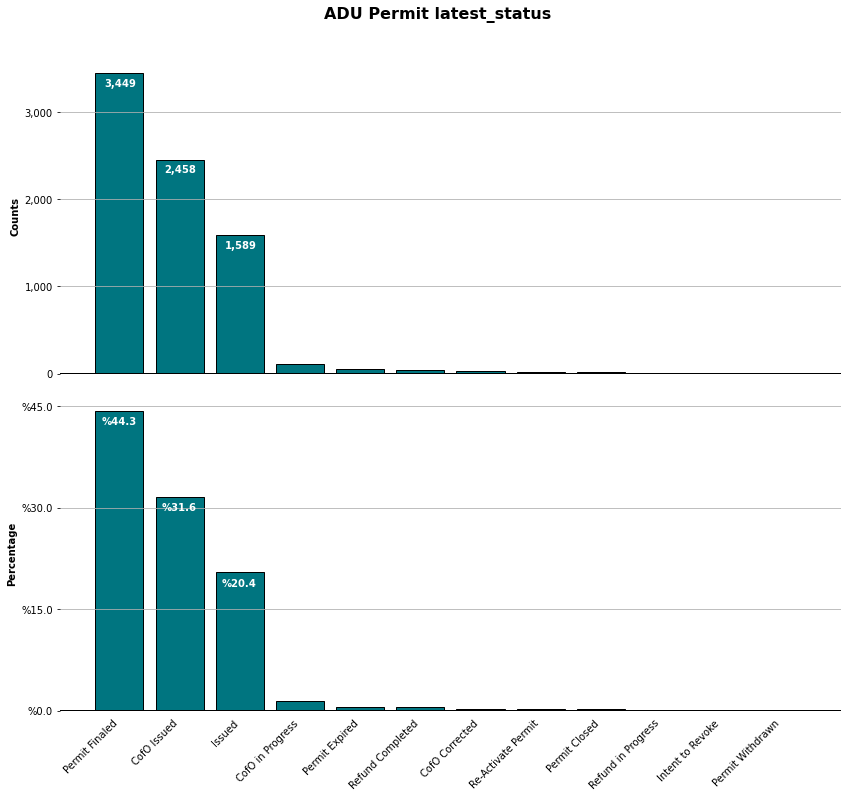

In [10]:
# Create the plots with matplotlib object-oriented API
fig, ax = plt.subplots(2,1, figsize=(14,12), sharex=True)
fig.suptitle('ADU Permit latest_status', fontweight='bold', fontsize='16', y=0.94)
plt.subplots_adjust(hspace=0.07)

##########################################################

ax[0].bar(x_labels, values, color='#007580', edgecolor='black') # Create the first graph of counts
# ax[0].set_title('Counts', fontweight='bold', fontsize='16') #Title for subplot 0

for i in range(3): # Label the bars
    ax[0].text(i-0.25, values[i]-150, '{:,}'.format(values[i]), c='white', fontweight='bold')
    
# ax[0].set_xticklabels(x_labels, rotation=45, ha='right') # Style the x labels for subplot 0
ax[0].xaxis.set_ticks_position('none') # Remove the x ticks from subplot 0

ax[0].set_ylabel('Counts', fontweight='bold')
yticks = np.arange(0, ax[0].get_ylim()[1]+50, 1000) # Define the y ticks
ax[0].set_yticks(yticks) # Set the y ticks
ax[0].set_yticklabels(['{:,.0f}'.format(i) for i in yticks]) # Style the y labels for subplot 0
ax[0].grid(axis='y') # Turn on the horizontal grid lines

ax[0].set_frame_on(False) # Turn off the frame
xmin, xmax = ax[0].get_xaxis().get_view_interval() # Get the View extents
ax[0].add_artist(Line2D((xmin,xmax),(0,0), color='black', linewidth=2)) # Add back the x-axis

##########################################################

ax[1].bar(x_labels_per, values_per, color='#007580', edgecolor='black') # Create the second graph of counts
# ax[1].set_title('Percentage', fontweight='bold', fontsize='16')

for i in range(3): # Label the bars
    ax[1].text(i-0.3, values_per[i]-2.0, '%{:,.1f}'.format(values_per[i]), c='white', fontweight='bold')
    
# ax[1].set_xlabel('Status Types', fontweight='bold')
ax[1].set_xticklabels(x_labels, rotation=45, ha='right') # Style the x labels for subplot 1
ax[1].xaxis.set_ticks_position('none') # Remove the x ticks from subplot 0

ax[1].set_ylabel('Percentage', fontweight='bold')
yticks = np.arange(0, ax[1].get_ylim()[1], 15) # Define the y ticks
ax[1].set_yticks(yticks) # Set the y ticks
ax[1].set_yticklabels(['%{:,.1f}'.format(i) for i in yticks]) # Style the y labels for subplot 1
ax[1].grid(axis='y') # Turn on the horizontal grid lines

ax[1].set_frame_on(False) # Turn off the frame
xmin, xmax = ax[1].get_xaxis().get_view_interval() # Get the View extents
ax[1].add_artist(Line2D((xmin,xmax),(0,0), color='black', linewidth=2)); # Add back the x-axis

# plt.savefig('./article/adu_data.png', dpi=400, bbox_inches='tight')

In [11]:
# fig, ax = plt.subplots(figsize=(14,6), sharex=True)
# fig.suptitle('ADU Permit latest_status', fontweight='bold', fontsize='16', y=0.94)

# # Create the first graph of counts
# ax.bar(x_labels, values, color='#007580', edgecolor='black')

# for i in range(3):
#     ax.text(i-0.25, values[i]-150, '{:,}'.format(values[i]), c='white', fontweight='bold')
    
# ax.set_xticklabels(x_labels, rotation=45, ha='right')
# ax.xaxis.set_ticks_position('none')

# ax.set_ylabel('Counts', fontweight='bold')
# yticks = np.arange(0, ax.get_ylim()[1]+50, 1000)
# ax.set_yticks(yticks)
# ax.set_yticklabels(['{:,.0f}'.format(i) for i in yticks])
# ax.grid(axis='y')

# ax.set_frame_on(False)
# xmin, xmax = ax.get_xaxis().get_view_interval()
# ax.add_artist(Line2D((xmin,xmax),(0,0), color='black', linewidth=2));

# plt.savefig('./article/adu_data.png', dpi=400, bbox_inches='tight')

Looks good and we can really see the dominance of the top three status types. So 31.6% of the ADU projects for which a permit was issued during the last six months of 2017 have been completed within three to four years.

Since time is a factor in this analysis, let's plot the issuance and project completions as a time series to get a better sense of the flow of events.

The first thing to do convert the `issue_date` to type datetime and confirm the time period of the issuance indeed matches what is stated in the description of the data set.

In [12]:
data['issue_date'] = pd.to_datetime(data['issue_date'], yearfirst=True)

In [13]:
data['issue_date'].min()

Timestamp('2017-07-03 00:00:00')

In [14]:
data['issue_date'].max()

Timestamp('2017-12-29 00:00:00')

So yes indeed the issue dates all fall within the last six months of 2017, weekends excluded. Now let's do a some time series plotting. For this I'm going to create a DataFrame with an index equal to `issue_date` and add a counter column, and then resample it to the week for plotting.

In [15]:
# Create pandas timeseries
data_ts_issued = pd.Series(data=1, index=data['issue_date']).resample('W').sum()

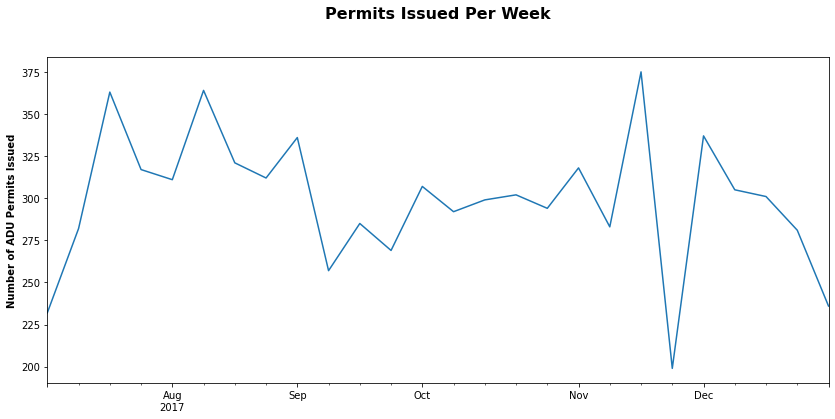

In [16]:
# Plot data using the pandas plotting methods and then style it with the pyplot API
data_ts_issued.plot(figsize=(14,6))
plt.ylabel('Number of ADU Permits Issued', fontweight='bold')
plt.xlabel('')
plt.title('Permits Issued Per Week', fontdict={'fontsize': 16,'fontweight':'bold'}, y=1.1);

# plt.savefig('./article/permits_issued.png', dpi=400, bbox_inches='tight')

Overall it seems as if permits were continually issued at a rate of 250 to 375 per week during the time period in question, except for the last week of November, which may be a result of the Thanksgiving holiday.

Now let's take a look at the completion rate. Again I'm going to create a separate dataframe that just includes the records in which `latest_status` equals "CofO Issued".

In [17]:
# Convert the `status_date` to type datetime and create a DataFrame for plotting just the projects that
# reached completion as of the time of this article. 
data['status_date'] = pd.to_datetime(data['status_date'], yearfirst=True)
data_cofo = pd.Series(data=(data['latest_status'] == 'CofO Issued').astype(int).ravel(), 
                      index=data['status_date']).resample('W').sum()

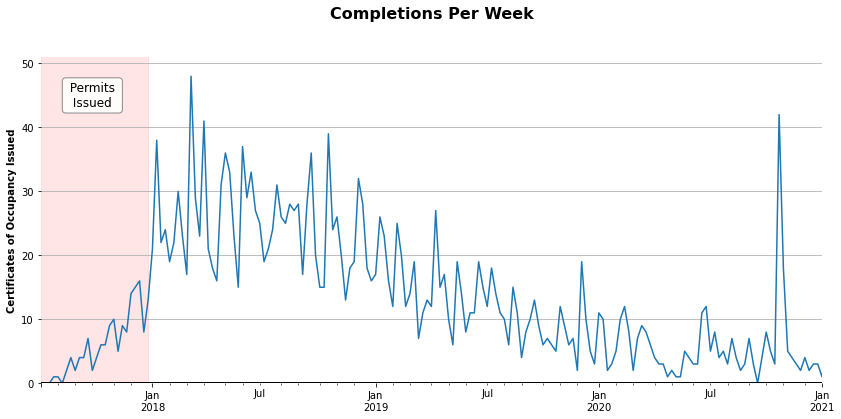

In [18]:
# Plot data using the pandas plotting methods and then style it with the pyplot API, then use the 
# object-oriented API to add a rectangular patch representing the time of permit issuance, format the
# y ticks, and turn off the frame and add back the x-axis. Note the use of plt.gca(), get current axis

data_cofo.plot(figsize=(14,6))
plt.ylabel('Certificates of Occupancy Issued', fontweight='bold')
plt.xlim(right='2021-01-01')
plt.xlabel('')
plt.ylim(0,51)
plt.title('Completions Per Week', fontdict={'fontsize': 16,'fontweight':'bold'}, y=1.1)

# Create the patch
start = datetime(2017, 7, 3)
end  = datetime(2017, 12, 31)
width = end - start
ymin, ymax = plt.ylim()
rect = plt.Rectangle((start,ymin), width, ymax+3, color='r', alpha=0.1)

# Add the rectangle to the current axis
ax = plt.gca() # Grab the current axis to style with the object oriented API
ax.add_patch(rect)

# Create a text box and add it to the axis
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(datetime(2017, 10, 1), 45, " Permits \n Issued ", ha="center", va="center", size=12,
        bbox=bbox_props)

# Style the y-axis
yticks = np.arange(0, ax.get_ylim()[1], 10)
ax.set_yticks(yticks)
ax.set_yticklabels(['{:,.0f}'.format(i) for i in yticks])
ax.grid(axis='y')

# Turn off the frame and add back an x-axis
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ax.add_artist(Line2D((xmin,xmax),(ymin,ymin), color='black', linewidth=2));
# plt.savefig('./article/permits_completed.png', dpi=400, bbox_inches='tight')

So it looks like the rate of completion grew steadily since the beginning of issuance, peaked in the spring of 2018 and then started to decline beginning in the winter of 2018. The trend downward continued throughout 2019. There is an unusually high peak in the fall of 2020, but of course this was a strange year due to the pandemic. Perhaps inspections were halted for most of the year, but started again in November, causing the big spike we see here.

Due to the unusual nature of 2020, I am going to constrain the analysis to a period of time that is equal to two years after the date of issuance. So the model will be set-up to predict the probability of completion within two years from the `issue_date`.

To get a better sense of the distribution of completion time, let's create a histogram of just that.

In [19]:
# Create a DataFrame for time to complete (ttc)
data['time_since_issue'] = data['status_date']-data['issue_date']
data_ttc = data[data['latest_status']=='CofO Issued']['time_since_issue']
data_ttc = pd.DataFrame(data_ttc.astype(int)/(60*60*24*1000000000)/7)

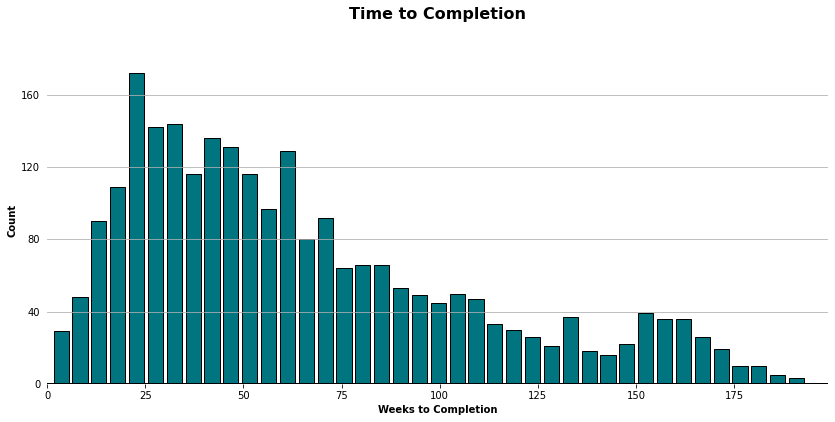

In [20]:
# In this case I'm explicitly defining the fig and axes in the beginning so I don't need to use plt.gca()
# later to stlye the plot. Note that while I am still using the pandas plotting method, I'm telling it on
# which axes to plot (ax=axes)
fig, axes = plt.subplots(figsize=(14,6))
data_ttc.hist(bins=40, rwidth=0.8, color='#007580', edgecolor='black', ax=axes)

plt.title('Time to Completion', fontdict={'fontsize': 16,'fontweight':'bold'}, y=1.1)
plt.xlabel('Weeks to Completion', fontweight='bold')
plt.xlim(0,199)
plt.ylabel('Count', fontweight='bold')
plt.yticks(np.arange(0, 165, 40))
plt.grid(axis='x')

axes.yaxis.set_ticks_position('none')
axes.set_frame_on(False)
xmin, xmax = axes.get_xlim()
axes.add_artist(Line2D((xmin,xmax),(0,0), color='black', linewidth=2));

# plt.savefig('./article/time_to_complete.png', dpi=400, bbox_inches='tight')

The mode is 20 weeks, in line with the peaking we saw in the timeseries plot of completions. We see a second, smaller peak at approximately 156 weeks, or three years, which agrees with the unusual peak we saw in fall of 2020.

# Code the Target Variable
Create a new column with a "1" if `latest_status` is "CofO Issued" and the `status_date` is less than two years from the `issue_date`. 

In [21]:
# Create datetime features for 2 years after the issues date of each permit
two_years = timedelta(365*2)
data['2_yr_from_issue']=data['issue_date']+two_years

In [22]:
data['cofo_issued'] = ((data['latest_status']=='CofO Issued') & (data['status_date']<=data['2_yr_from_issue'])).astype(int)

In [23]:
data['cofo_issued'].value_counts()

0    5778
1    2000
Name: cofo_issued, dtype: int64

In [24]:
del data['latest_status']
del data['status_date']

# Analyze the Nulls
Let's take a look at the number of null values in each columns. Variables with significant number of nulls probably won't be very predictive and can be eliminated.

In [25]:
# Just taking a look a the current setting for maximum number of rows displayed
pd.options.display.max_rows

60

In [26]:
# Looks like we'll be able to see all variables
(data.isnull().sum()/len(data)).sort_values()

zip_code                                   0.000000
time_since_issue                           0.000000
geometry                                   0.000000
APN                                        0.000000
2_yr_from_issue                            0.000000
council_district                           0.000000
permit_sub_type                            0.000000
issue_date                                 0.000000
license                                    0.000000
street_name                                0.000000
address_start                              0.000000
pcis_permit                                0.000000
valuation                                  0.000000
permit_type                                0.000000
cofo_issued                                0.000000
address_end                                0.000000
reference_old_permit                       0.000000
census_tract                               0.000000
permit_category                            0.000000
work_descrip

I'm going to drop all columns that have more that 50% of the records null, except hillside, which is a variable we created when we developed the data set and thus we know that 78% of the records are not built on a hillside. Furthermore, many of these variables look as if they would have litte predictive power, such as names of principals and contractors. I'm also going to drop parts of addresses, as they too would have little predictive power.

In [27]:
del data['principal_first_name']
del data['principal_last_name']
del data['contractor_address']
del data['contractor_city']
del data['contractor_state']
del data['principal_middle_name']
del data['of_residential_dwelling_units']
del data['block']
del data['applicant_address_2']
del data['applicant_business_name']
del data['address_fraction_end']
del data['address_fraction_start']
del data['occupancy']
del data['unit_range_start']
del data['suffix_direction']
del data['unit_range_end']
del data['project_number']

I'm also going to remove address elements because we already have the location of the site in both the latitude and longitude and geometry variables.

In [28]:
del data['address_start']
del data['address_end']
del data['street_name']
del data['street_direction']
del data['street_suffix']

# Remove Extraneous Identifiers
Now let's take out the various codes that are in the data set which we have already leveraged when we developed it (see my post "Los Angeles City Civic Data").

In [29]:
del data['tract']
del data['lot']
del data['census_tract']
del data['APN']
del data['reference_old_permit']
del data['pcis_permit']

I'm also going to remove `license`, which is the contract's license, and `license_expiration_date` as they are just numerical identifiers. The fact that the project was put forth by a contractor may be of significance, but I will capture that later in the `license_type` variable.

In [30]:
del data['license']
del data['license_expiration_date']

# Analyze Categorical Variables
Before we dig into the details of individual categorical variables, let's first summarize the state of our data set at the moment.

In [31]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7778 entries, 0 to 7777
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype          
---  ------                                   --------------  -----          
 0   zip_code                                 7778 non-null   object         
 1   work_description                         7778 non-null   object         
 2   permit_category                          7778 non-null   object         
 3   initiating_office                        7778 non-null   object         
 4   applicant_first_name                     7639 non-null   object         
 5   zone                                     7772 non-null   object         
 6   applicant_address_1                      5383 non-null   object         
 7   license_type                             7778 non-null   object         
 8   valuation                                7778 non-null   object         
 9   applicant_relationship

## applicant_relationship
Looking down the list of variables above I first wonder what `applicant_relationship` is, and if there is something about it that could be predictive of completion. If not, I can eliminate it from this set and also the four other associated variables. 

In [32]:
# Get a list of unique records for 'applicant_relationship'
data['applicant_relationship'].value_counts()

Agent for Owner         4280
Owner                    772
Architect                703
Agent for Contractor     656
Contractor               463
Owner-Bldr               359
Other                    271
Engineer                 134
Developer                 10
Net Applicant              2
Tenant                     1
Name: applicant_relationship, dtype: int64

In [33]:
data['applicant_relationship'].value_counts(normalize=True)

Agent for Owner         0.559404
Owner                   0.100902
Architect               0.091883
Agent for Contractor    0.085740
Contractor              0.060515
Owner-Bldr              0.046922
Other                   0.035420
Engineer                0.017514
Developer               0.001307
Net Applicant           0.000261
Tenant                  0.000131
Name: applicant_relationship, dtype: float64

So it looks like almost 56% of the applicants are "Agent for Owner", and 10% are by the "Owner" him or herself. Then "Architect" at 9% and "Agent for Contractor" and "Contractor" (which can probably be treated as the same) at a combined 15%. 

Let's take a look at how completion rates vary by `applicant_relationship`.

In [34]:
data.groupby('applicant_relationship').apply(lambda x: x.cofo_issued.sum() / x.cofo_issued.count())\
    .sort_values(ascending=False)

applicant_relationship
Net Applicant           0.500000
Owner                   0.299223
Agent for Owner         0.292991
Owner-Bldr              0.261838
Other                   0.214022
Architect               0.206259
Contractor              0.170626
Agent for Contractor    0.167683
Engineer                0.164179
Tenant                  0.000000
Developer               0.000000
dtype: float64

Interesting result. 

The completion rates within two years are almost 30% for "Agents of Owners" and "Owners", 26% for "Owner_bldr", 21% for "Architect" and "Other" and 17% for "Contractor" and "Contractor|. Seeing this distribution of values we should keep `applicant_relationship` in the model, although we may want to combined some of these categories to minimize the number of categorical variables that we have to one hot encode later.

Let's make a nice plot of this.

In [35]:
app_rel_rate = data.groupby('applicant_relationship').apply(lambda x: x.cofo_issued.sum() / x.cofo_issued.count())\
    .sort_values(ascending=False)
app_rel_counts = [data['applicant_relationship'].value_counts()[x] for x in app_rel_rate.index]

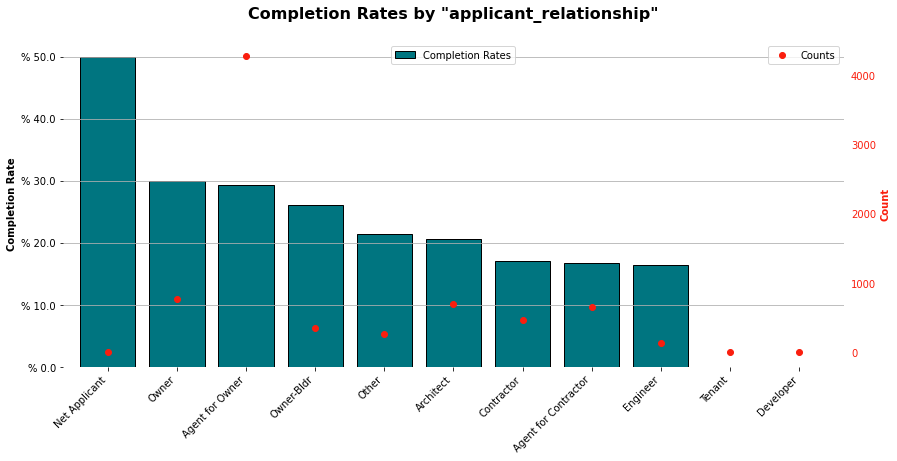

In [36]:
# Make a chart with two y-axis. I'm first going to use plot the completion rates with the pandas plotting
# module, style it with the pyplot API, then get the current axes with plt.gca() and create the second axis

app_rel_rate.plot(kind='bar', rot=45, figsize =(14,6), color='#007580', width=0.8,
                                      edgecolor='black', label='Completion Rates')
plt.title('Completion Rates by "applicant_relationship"', fontsize=16, fontweight='bold', y=1.05)
plt.xlabel('')
plt.ylabel('Completion Rate', fontweight='bold')
plt.xticks(ha='right')
yticks = np.arange(0, 0.6, 0.1)
plt.yticks(ticks=yticks, labels=[f'%{i*100: 0.1f}' for i in yticks])
plt.grid(axis='y')
plt.legend(loc='upper center')

ax1=plt.gca()
ax1.set_frame_on(False)
ax1.yaxis.set_ticks_position('none')
xmin, xmax = ax.get_xlim()
ax1.add_artist(Line2D((xmin,xmax),(0,0), color='black', linewidth=2))

ax2 = ax1.twinx() # This creates the second axis with the same x-axis
plt.scatter(app_rel_rate.index, app_rel_counts, color='#fa1e0e', label='Counts')
ax2.set_ylabel('Count', color='#fa1e0e', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#fa1e0e')
ax2.set_frame_on(False)
ax2.yaxis.set_ticks_position('none')
plt.legend();

# plt.savefig('./article/completion_rates.png', dpi=400, bbox_inches='tight')

But I think we can eliminate the other four variables that are simply identifying elements of the particular applicant involved.

In [37]:
del data['applicant_address_1']
del data['applicant_address_3']
del data['applicant_first_name']
del data['applicant_last_name']

And finally let's deal with the null values for this variable while we're here.

In [38]:
data['applicant_relationship'].fillna('None', inplace=True)

## work_description

Work description looks very detailed. Something predictive may be teased out of this text after first analyzing it, but I think there is lower hanging fruit to go after before going down that path.

In [39]:
data['work_description'][:5]

0    CHANGING OUT NEW WINDOWS AND NEW WOOD SIDING O...
1    CHANGE OF ADDRESS FOR STORAGE BLDG.  ACCESSORY...
2    supplemental ref to permit #17016-70000-21527 ...
3    INTERIOR REMODEL TO EXISTING SINGLE FAMILY DWE...
4    SUPPLEMENTAL TO 16010-20000-02035: TO INSTALL ...
Name: work_description, dtype: object

In [40]:
del data['work_description']

## zone
Wow, there are a lot of zoning codes in LA! Trying to understand them all looks like a Herculean task. Taking my clues from the radio segment mentioned earlier, I'm primarily interested in areas that are a Historic Preservation Overlay Zone, as an ADU in those areas would have to go through additional screening.

In [41]:
data['zone'].unique()

array(['[Q]C4-1XL-HPOZ', 'R2-1VL', 'RD3-1', '[T]RE-1', 'RE40-1-H', 'R1-1',
       'RA-1', 'A2-1', 'RE20-1-H', 'RD2-1', 'RE15-1', 'RE11-1',
       'RE20-1-H-HCR', 'RE40-1-H-HCR', 'RE15-1-H', 'RE20-1', 'R1-1-RIO',
       'R1-1-RFA', 'RD1.5-1-O-HPOZ', 'RD2-1-HPOZ', 'RE40-1-K',
       'RD1.5-1XL', 'RE40-1', 'R1V2', '[Q]RD3-1XL', 'A1-1-O-K', 'RS-1',
       'R2-1XL', 'R1-1-RFA-RIO', 'RE15-1-H-HCR', '[T][Q]C2-1-O-CA',
       'RE9-1', '(T)(Q)RD3-1', 'A1-1', '[Q]R5-3', 'R3-1', '(T)(Q)RD5-1',
       '(T)(Q)R1-1', 'RD1.5-1-O', 'RD1.5-1-HPOZ', 'RD1.5-1', '(Q)RD2-1',
       'RA-1-K', nan, 'R3P-1VL', 'R3-1-O', 'R1-1XL', 'R1-1-CUGU',
       '[Q]R3-1XL', '(T)(Q)RD6-1VL', '(T)R4-1', 'RS-1-O', '[Q]C2-1',
       'RS-1-CUGU', 'RD3-1VL', '(T)R1-1', 'RE11-1-RIO', 'R2-1',
       '[Q]R4-1VL', 'RE40-1-HCR', '[Q]RD3-1D', '(Q)RD6-1', 'R1-1-K',
       '(T)RS-1', 'M2-1', 'RE9-1XL-RFA', 'R2-1-HPOZ', 'R1-1-O-CUGU',
       'R1-1-O', 'R1R3-RG-O', '[Q]R1-1D', 'R1-1VL', 'R1-1VLD',
       'R1-1-HPOZ', 'RE9-1-HPOZ', 'R1-1

Thus let's do a little regex to tag records that have "HPOZ" in their zone.

In [42]:
data['zone'] = data['zone'].apply(lambda x: 'HPOZ' if re.search('HPOZ', str(x)) else 'no-HPOZ')

Less than 5% of the data set are HPOZ, but that 5% has a completion rate that is notably lower than the rest of the records, so it may have predictive power.

In [43]:
data['zone'].value_counts()

no-HPOZ    7459
HPOZ        319
Name: zone, dtype: int64

In [44]:
data.groupby('zone').apply(lambda x: x.cofo_issued.sum() / x.cofo_issued.count())\
    .sort_values(ascending=False)

zone
no-HPOZ    0.260223
HPOZ       0.184953
dtype: float64

## permit_type, permit_sub_type and permit_category

`permit_type` is dominated by two entries, "Bldg-Alter-Repair" and "Bldg-Addition".

In [45]:
data['permit_type'].value_counts()

Bldg-Alter/Repair       4818
Bldg-Addition           2854
Nonbldg-Alter/Repair      94
Nonbldg-Addition          12
Name: permit_type, dtype: int64

And the completion rates are significantly different between the two, so we should hold on to these variables.

In [46]:
data.groupby('permit_type').apply(lambda x: x.cofo_issued.sum() / x.cofo_issued.count())\
    .sort_values(ascending=False)

permit_type
Bldg-Addition           0.485284
Bldg-Alter/Repair       0.127646
Nonbldg-Alter/Repair    0.000000
Nonbldg-Addition        0.000000
dtype: float64

Both `permit_category` and `permit_sub_type` only have a single unique entry, so can be safely eliminated.

In [47]:
print(data['permit_category'].value_counts())
print(data['permit_sub_type'].value_counts())

Plan Check    7778
Name: permit_category, dtype: int64
1 or 2 Family Dwelling    7778
Name: permit_sub_type, dtype: int64


In [48]:
del data['permit_category']
del data['permit_sub_type']

## initiating_office
I would keep these variables in the model as there may be effects from different administering organizations. We can see from the below that the completion rates vary by office. There are only five unique entries so can be modeled fairly easily.

In [49]:
data['initiating_office'].value_counts()

VAN NUYS    3756
METRO       2146
WEST LA     1425
SOUTH LA     315
SANPEDRO     136
Name: initiating_office, dtype: int64

In [50]:
data.groupby('initiating_office').apply(lambda x: x.cofo_issued.sum() / x.cofo_issued.count())\
    .sort_values(ascending=False)

initiating_office
VAN NUYS    0.319755
SOUTH LA    0.266667
SANPEDRO    0.213235
WEST LA     0.200702
METRO       0.186393
dtype: float64

## license_type
The license type is dominated by "B" - General Building Contractor. The number of other types of licenses are insignificant. I'm concluding that "NA" is indeed "Not Applicable" given its absence from 
this <a href="https://www.cslb.ca.gov/About_Us/Library/Licensing_Classifications/">list of license types in California.</a>

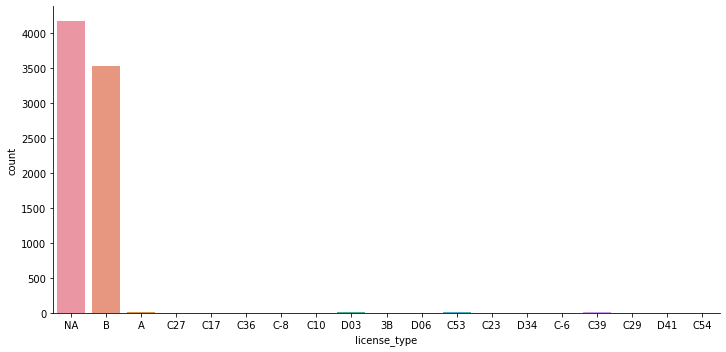

In [51]:
# Let's make a chart with Seaboarn to to mix things up a bit
sns.catplot(x='license_type', kind="count", data=data, height=5, aspect=2);

Taking a quick look at the completion rates between the two ("B" = 19.4%, "NA" = 31.1%) leads me to leave this variable in the model, but simplify it so that it only contains two license types - "B" or "None".

In [52]:
data.groupby('license_type').apply(lambda x: x.cofo_issued.sum() / x.cofo_issued.count()).sort_index()

license_type
3B     0.000000
A      0.000000
B      0.194625
C-6    0.000000
C-8    0.000000
C10    0.200000
C17    0.500000
C23    0.000000
C27    0.500000
C29    0.000000
C36    0.000000
C39    0.000000
C53    0.166667
C54    0.000000
D03    0.500000
D06    0.000000
D34    0.000000
D41    0.000000
NA     0.311707
dtype: float64

In [53]:
data['license_type']=data['license_type'].apply(lambda x: 'None' if x != 'B' else x)

## contractors_business_name
Taking a look at this variable it seems as if it would not offer that much predictive power. Also, with over 1800 unique `contractor_business_name` entries, it would take some separate analysis to distill it down into a usable model variable.

In [54]:
data['contractors_business_name'].unique()

array(['OWNER-BUILDER', 'NELA BUILDERS & DESIGN INC', 'SHAPELL HOMES INC',
       ..., 'GONZALEZ JAV CONSTRUCTION AND REMODELING',
       'KROUS LEON DRILLING INC', 'CECILIA CLARKE'], dtype=object)

In [55]:
len(data['contractors_business_name'].unique())

1814

In [56]:
del data['contractors_business_name']

## of_stories
Although the data in this variable is numerical, I'm going to treat it as a categorical variable since there are only six unique values. I'm not sure why so many buildings have zero stories. Seems like just an input error. But without better knowledge of how the data is created, let's go with it.

In [57]:
data['of_stories'].value_counts()

1    1755
0    1399
2     808
3      52
4       2
5       1
Name: of_stories, dtype: int64

In [58]:
# Convert the values to strings and handle the nulls
data['of_stories'] = data['of_stories'].astype(str)
data['of_stories'].fillna('None', inplace=True)

## Hillsides
This is a binary variable that we created in the ETL class, as an indicator that the project is within the hillside ordinance. 1,694 records, or 21.8% of the data set, are hillisde projects. All I'm going to do here is input the nulls to zero.

In [59]:
data['hillside']

0       1.0
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
7773    NaN
7774    NaN
7775    1.0
7776    1.0
7777    1.0
Name: hillside, Length: 7778, dtype: float64

In [60]:
data['hillside'] = data['hillside'].fillna(0)

Projects built on a hillside have a 14.4% completion rate verses 28.9% for the remainder of the data set.

In [61]:
data.groupby('hillside').apply(lambda x: x.cofo_issued.sum() / x.cofo_issued.count())\
    .sort_values(ascending=False)

hillside
0.0    0.288626
1.0    0.144038
dtype: float64

In [62]:
data.groupby(['zone','hillside']).apply(lambda x: x.cofo_issued.sum() / x.cofo_issued.count())\
    .sort_values(ascending=False)

zone     hillside
no-HPOZ  0.0         0.293145
HPOZ     0.0         0.194245
no-HPOZ  1.0         0.144586
HPOZ     1.0         0.121951
dtype: float64

# Analyze Numerical Variables
Now let's turn our attention to the numerical variables. 

In [63]:
# Lets remind ourselves what's now left in the DataFrame data.
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7778 entries, 0 to 7777
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype          
---  ------                                   --------------  -----          
 0   zip_code                                 7778 non-null   object         
 1   initiating_office                        7778 non-null   object         
 2   zone                                     7778 non-null   object         
 3   license_type                             7778 non-null   object         
 4   valuation                                7778 non-null   object         
 5   applicant_relationship                   7778 non-null   object         
 6   issue_date                               7778 non-null   datetime64[ns] 
 7   council_district                         7778 non-null   object         
 8   permit_type                              7778 non-null   object         
 9   floor_area_l_a_buildin

First I'm going to simplify the names of the `floor_area` variables so that they are more readable on a graph.

In [64]:
data.rename(columns={'floor_area_l_a_building_code_definition':'bldg_code_floor_area',
                     'floor_area_l_a_zoning_code_definition':'zone_code_floor_area'}, inplace=True)

In [65]:
# Make a list of numerical variables
num_var = ['valuation', 'bldg_code_floor_area','zone_code_floor_area','median_income',
          'building_size','lot_size','open_land']

In [66]:
# Convert all numerical values to floats
for dtype in num_var:
    data[dtype] = data[dtype].astype(float)

## Correlations
First let's create a quick correlation matrix.

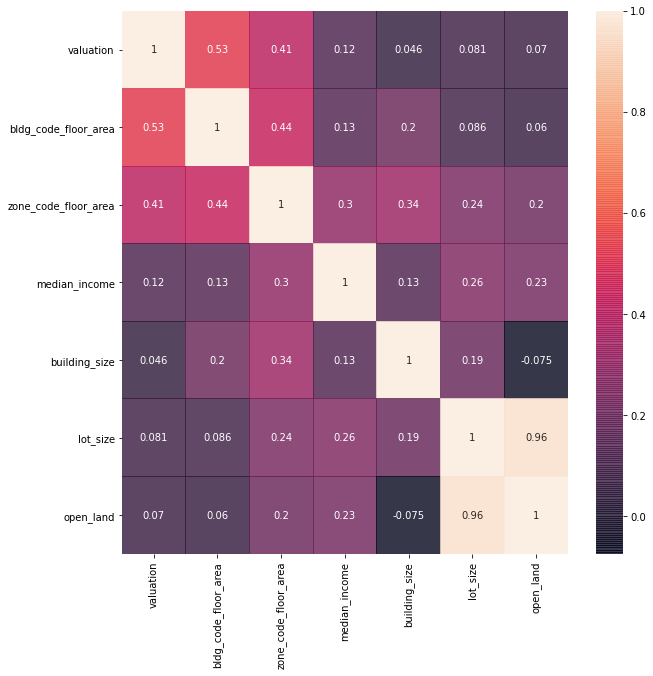

In [67]:
plt.subplots(figsize=(10,10)) # Use plt.subplots to set the figure size
sns.heatmap(data[num_var].corr(), alpha=0.8, annot=True);

The two highly correlated variables are `lot_size_ln` and `open_land_ln`. It seems vary logical that these would be highly correlated. Since we derived `open_land` when we created the data set (`lot_size` minus the sum of the square footages of all the dwellings on the property, see “Aggregating Data for LA City Data Science”), we'll remove `open_land_ln` since that variable was derived.

It's also not surprising that there is some correlation between the median income in the neighborhood (this variable was determined at the census tract level) and the size of the lots.

It's also interesting to note `median_income_ln` and `valuation_ln` aren't correlated. This isn't intuitive as I would have thought that the wealthier the neighborhood, the bigger and more expensive the projects.

In [68]:
num_var.remove('open_land')
del data['open_land']

## Distributions

For the numerical variables, let's take a high level view of all of them to help orient ourselves to the variables with which we're working.

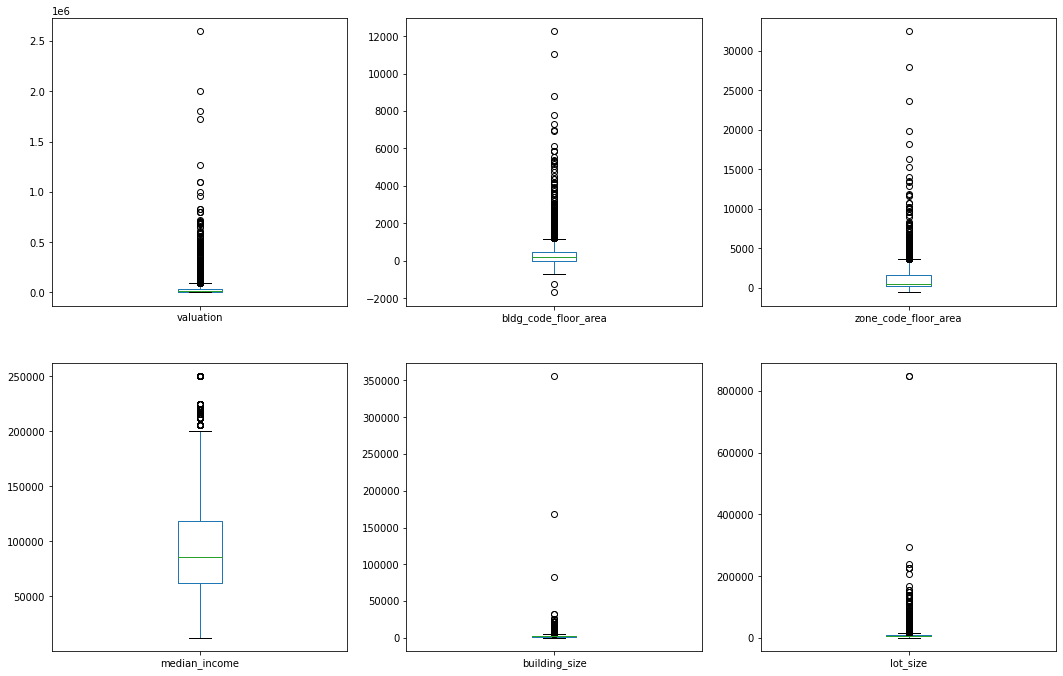

In [69]:
# The pandas plotting module has a subplots attribute
data[num_var].astype(float).plot(kind='box', figsize=(18,18), subplots=True, layout=(3,3));

Several of our numerical variables have a very narrow box, meaning the middle 50% of the values, or the interquartile range, are very tightly clustered together. In fact in some cases the whiskers are not even visible, just the outliers.

I'd like to get a sense of the distribution around the medians so I'm going to set the limits of the following density plots to the IQR.

In [70]:
# Create a dictionary of tuples that contatin the 25% and the 75% values for each numerical feature
num_var_iqr={}
for feature, iqr in enumerate(zip(data[num_var].describe().loc['25%'],data[num_var].describe().loc['75%'])):
    num_var_iqr[num_var[feature]] = iqr

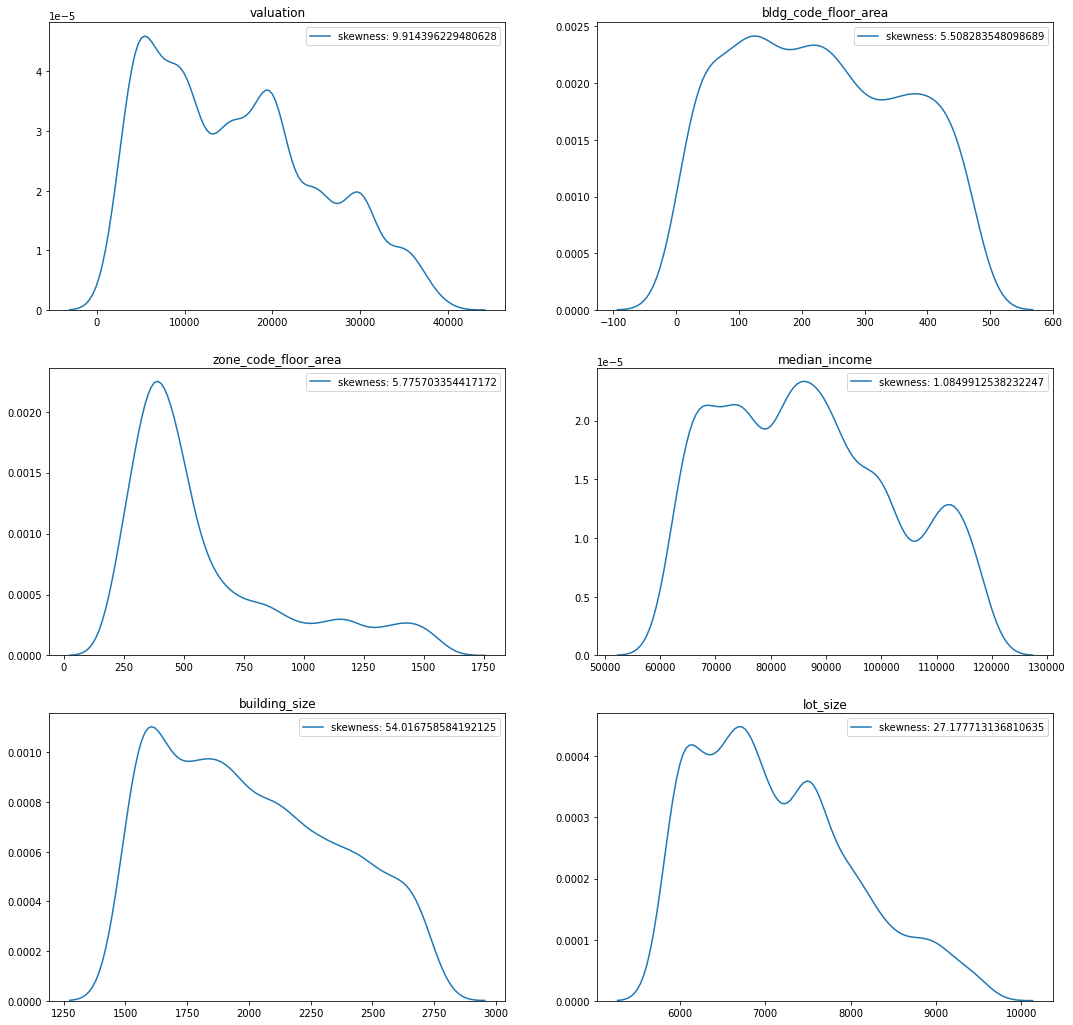

In [71]:
# Plot the interquartile range of the numerical features. Here I'm defining 6 subplots and then looping
# over them
fig, axes = plt.subplots(3, 2, figsize=(18,18))
axes = axes.ravel()
for i,feat in enumerate(num_var):
    sns.kdeplot(data[feat], clip=num_var_iqr[feat], ax=axes[i], label=f'skewness: {data[feat].skew()}')
    axes[i].set_title(feat);

All of them look like they have some degree of skewness, so let's perform a log transformation to see if we get a better distribution.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


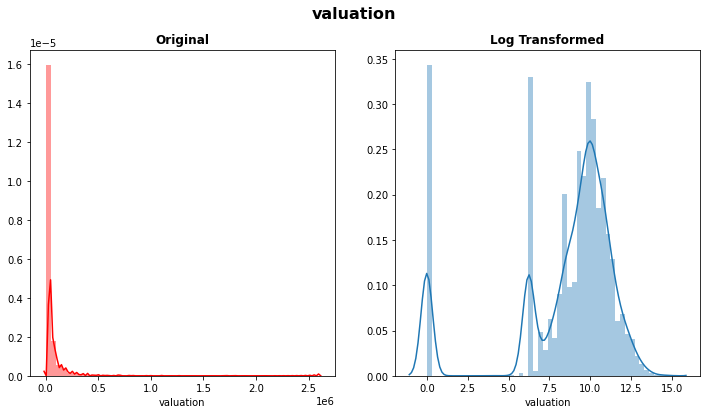

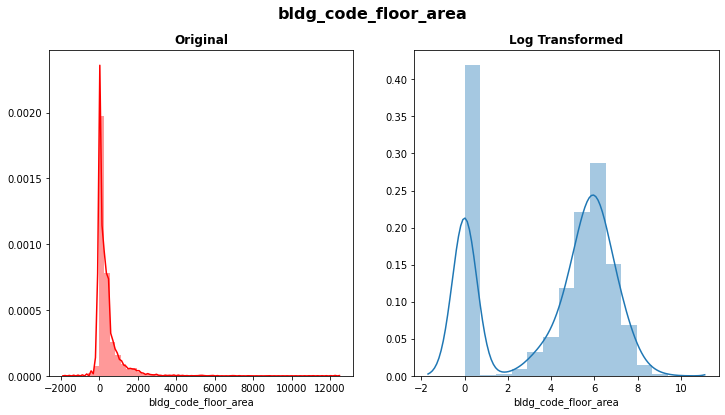

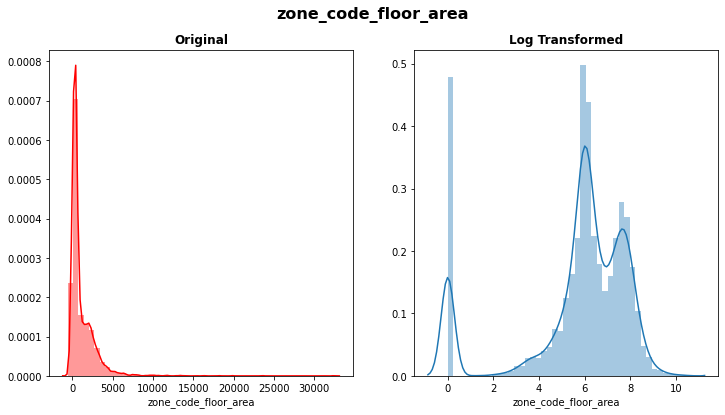

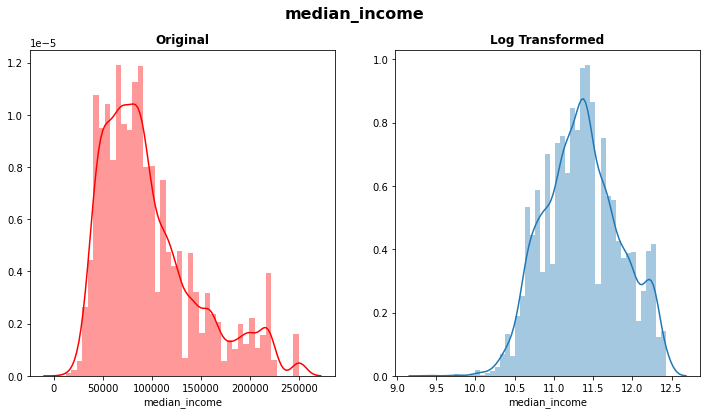

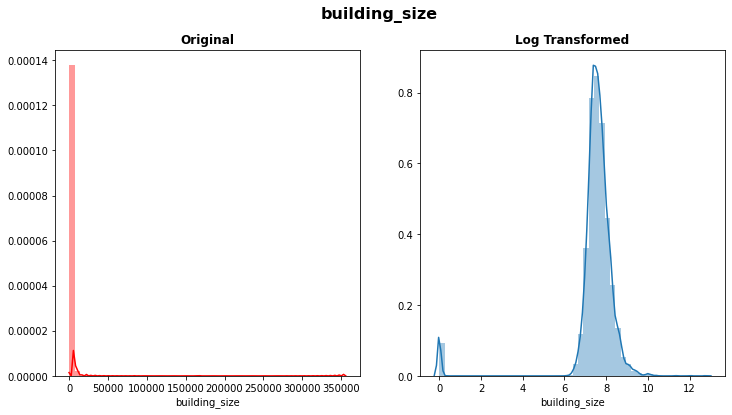

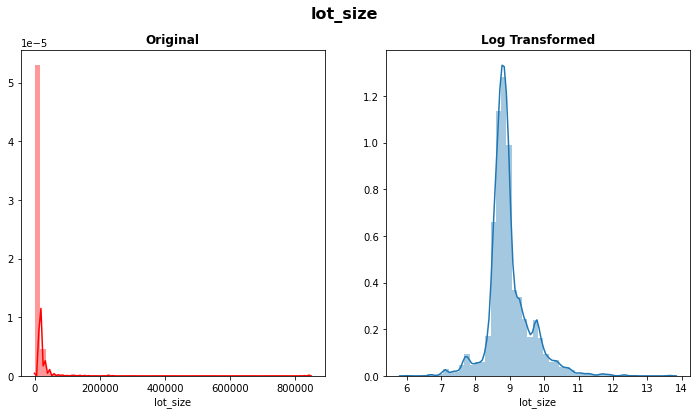

In [72]:
# In this case I create a loop that creates a pair of axes in each iteration
for feat in num_var:
    fig,axes = plt.subplots(1,2)
    fig.set_size_inches(12,6)
    sns.distplot(data[feat], label=f'Original', color='red', ax=axes[0])
    axes[0].set_title('Original', fontweight='bold')
    
    sns.distplot(np.log1p(data[feat]),label='Log', ax=axes[1])
    axes[1].set_title('Log Transformed', fontweight='bold')
    
    fig.suptitle(feat, fontweight='bold', fontsize='16');

In pretty much all of these cases we see a high level of skewness and an improved distribution after taking the log of the variable, so let's make these transformations official in our data set.

I'll first imput the null values and change any negative values to zeros before then perform the log transformations.

In [73]:
# For variables with less than 5% of the values null I'm going to imput with the mean of the existing values
data['median_income'] = data['median_income'].fillna(data['median_income'].mean())
data['lot_size'] = data['lot_size'].fillna(data['lot_size'].mean())
data['building_size'] = data['building_size'].fillna(data['building_size'].mean())
# For the remainder of the numerical variables I'm going to imput with zero
data['bldg_code_floor_area'] = data['bldg_code_floor_area'].fillna(0)
data['zone_code_floor_area'] = data['zone_code_floor_area'].fillna(0)

In [74]:
# Transform negative values to zeros
data['bldg_code_floor_area'] = data['bldg_code_floor_area'].apply(lambda x: 0 if x<0 else x)
data['zone_code_floor_area'] = data['zone_code_floor_area'].apply(lambda x: 0 if x<0 else x)

In [75]:
# Take the log of the numerical variables and delete the original variables
for feat in num_var:
    data[feat+'_ln'] = np.log1p(data[feat])
    del data[feat]

In [76]:
# Update our list of numerical features
num_var = [x+'_ln' for x in num_var]

# Analyze the Locations

In [77]:
# Summary of where the data set is now
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7778 entries, 0 to 7777
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   zip_code                 7778 non-null   object         
 1   initiating_office        7778 non-null   object         
 2   zone                     7778 non-null   object         
 3   license_type             7778 non-null   object         
 4   applicant_relationship   7778 non-null   object         
 5   issue_date               7778 non-null   datetime64[ns] 
 6   council_district         7778 non-null   object         
 7   permit_type              7778 non-null   object         
 8   of_stories               7778 non-null   object         
 9   geometry                 7778 non-null   geometry       
 10  hillside                 7778 non-null   float64        
 11  time_since_issue         7778 non-null   timedelta64[ns]
 12  2_yr_from_is

In order to get a high level view of where the projects are located geographically I'm going to create a simple dot density map.

In [78]:
map = Basemap(urcrnrlat=34.380372,     # top
              urcrnrlon=-117.991737,   # bottom
              llcrnrlat=33.636499,     # left
              llcrnrlon=-118.774135,   # right
              epsg=3857)

In [79]:
lon_0 = [float(i) for i in data[data['cofo_issued']==0]['geometry'].x]
lat_0 = [float(i) for i in data[data['cofo_issued']==0]['geometry'].y]
x_0, y_0 = map(lon_0,lat_0)

lon_1 = [float(i) for i in data[data['cofo_issued']==1]['geometry'].x]
lat_1 = [float(i) for i in data[data['cofo_issued']==1]['geometry'].y]
x_1, y_1 = map(lon_1,lat_1)

In [80]:
width = 20
height = 10
dpi = 96
xpixels = dpi*width

/Users/seymourliao/Library/Python/3.6/lib/python/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


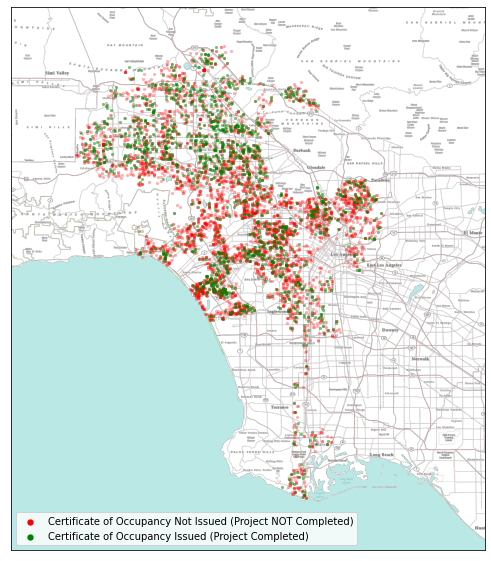

In [81]:
# Use basemap for open source mapping
plt.gcf().set_size_inches(width,height)
map.arcgisimage(service='Reference/World_Reference_Overlay',
                xpixels=xpixels)
map.scatter(x_0,y_0, c='r', alpha=0.3, s=10, linewidths=0, label='Certificate of Occupancy Not Issued (Project NOT Completed)')
map.scatter(x_1,y_1, c='g', alpha=0.5, s=10, linewidths=0, label='Certificate of Occupancy Issued (Project Completed)')
leg = plt.legend(loc='lower left', markerscale=2)
for lh in leg.legendHandles:
    lh.set_alpha(1);

# plt.savefig('./article/locs.png', dpi=400, bbox_inches='tight')

So it looks like the locations of the ADU projects in this data set are fairly evenly spread out across the city of Los Angeles, with high concentrations in the central and eastern portions of the city.

It would be nice to include the locations but without making the DataFrame too large once we OneHotEncode all the categorial variables. In order to reduce all of these locations down a bit I'm going to run a k-means clustering on the raw latitude and longitude data to see if any natural clusters occur.

In [82]:
# First let's create a new DataFrame, preserving the original index (as we'll merge the results back onto
# the data DataFrame to create the new "geo cluster" feature.) Also, point locations must be of type str.
geo_df = pd.DataFrame({'latitude':data.geometry.y, 'longitude':data.geometry.x})

In [83]:
geo_df = geo_df[geo_df['latitude'].notna() & geo_df['longitude'].notna()]

In [84]:
# Loop though a number of different clusters an collect their silhouette and ssd scores
silhouette_scores = []
ssd = []
for n_clusters in range(2,30):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(geo_df)
    score = silhouette_score(geo_df, preds, metric='euclidean')
    silhouette_scores.append(score)
    ssd.append(clusterer.inertia_)

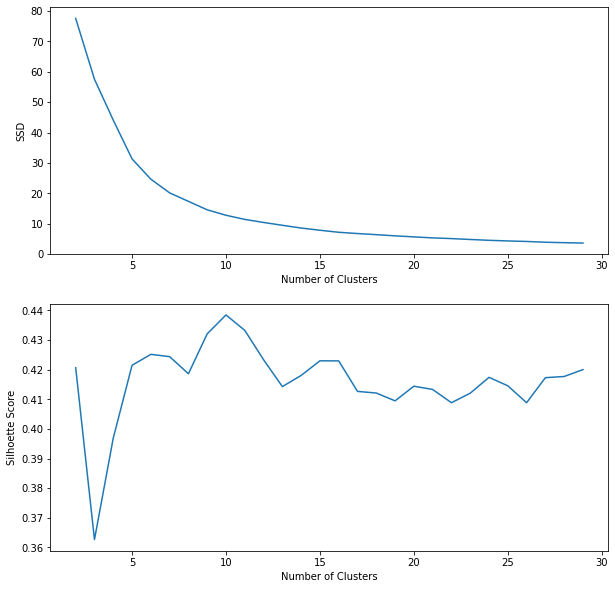

In [85]:
# Note with plt.subplots you can specify the name of all the axes if you wish
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

plt.sca(ax1)
plt.plot(range(2,30), ssd)
plt.ylabel('SSD')
plt.xlabel('Number of Clusters')

plt.sca(ax2)
plt.plot(range(2,30), silhouette_scores)
plt.ylabel('Silhoette Score')
plt.xlabel('Number of Clusters');

Given that the Silhouette score peaks at 10 clusters and the bend in the SSD score is in the neighborhood of 10 let's use 10 clusters in our K-mean model.

In [86]:
# Run K-means models with 10 clusters
km = KMeans(n_clusters=10)
km.fit(geo_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [87]:
# Now predict the cluster for each record in the geo DataFrame
geo_df['geo_cluster'] = km.predict(geo_df)

Notice the indexing from the data DataFrame is preserved so it can be easily merged back onto the ADU data set.

In [88]:
geo_df[:5]

,latitude,longitude,geo_cluster
0,34.11747,-118.18674,2
2,34.06971,-118.20629,2
3,34.06971,-118.20629,2
6,34.10090,-118.43407,9
7,34.09701,-118.38108,0


In [89]:
# merge the geo cluster onto data by the index
data = pd.merge(data, geo_df, left_index=True, right_index=True, how='left')
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7778 entries, 0 to 7777
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   zip_code                 7778 non-null   object         
 1   initiating_office        7778 non-null   object         
 2   zone                     7778 non-null   object         
 3   license_type             7778 non-null   object         
 4   applicant_relationship   7778 non-null   object         
 5   issue_date               7778 non-null   datetime64[ns] 
 6   council_district         7778 non-null   object         
 7   permit_type              7778 non-null   object         
 8   of_stories               7778 non-null   object         
 9   geometry                 7778 non-null   geometry       
 10  hillside                 7778 non-null   float64        
 11  time_since_issue         7778 non-null   timedelta64[ns]
 12  2_yr_from_is

Now let's plot these clusters to see what the k-mean algorithm created.

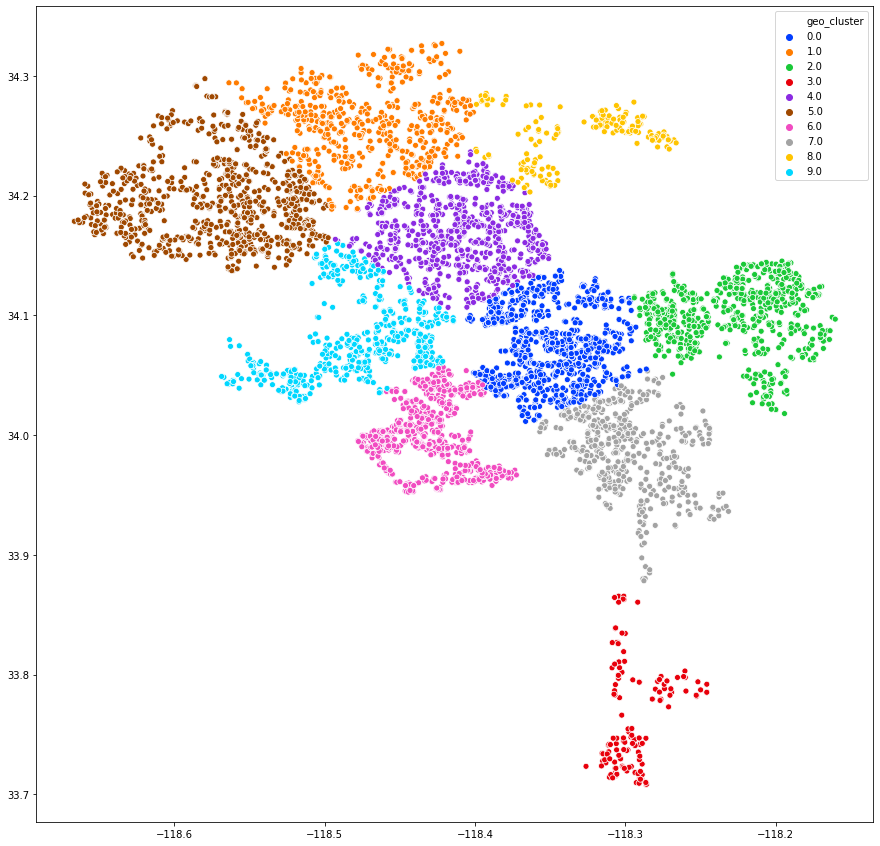

In [90]:
plt.subplots(figsize=(15,15))
sns.scatterplot(x=data['geometry'].x, y=data['geometry'].y, hue=data['geo_cluster'], palette='bright');

So it looks like K-means has found clusters that are largely geographic in nature, which makes sense.

In [91]:
# Convert the variable to type str for OneHotEncoding
data['geo_cluster'] = data['geo_cluster'].astype(str)

In [92]:
# Impute nulls
data['geo_cluster'] = data['geo_cluster'].fillna('None')
data['latitude'] = data['latitude'].fillna(0)
data['longitude'] = data['longitude'].fillna(0)

As a final clean-up I'm going to delete `zip_code` from the data set since we've captured more location specific features in other ways. Also, I'm going to remove the columns that won't be used in the model.

In [93]:
del data['zip_code']
del data['geometry']
del data['2_yr_from_issue']

# One Hot Encodeing

In [94]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7778 entries, 0 to 7777
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   initiating_office        7778 non-null   object         
 1   zone                     7778 non-null   object         
 2   license_type             7778 non-null   object         
 3   applicant_relationship   7778 non-null   object         
 4   issue_date               7778 non-null   datetime64[ns] 
 5   council_district         7778 non-null   object         
 6   permit_type              7778 non-null   object         
 7   of_stories               7778 non-null   object         
 8   hillside                 7778 non-null   float64        
 9   time_since_issue         7778 non-null   timedelta64[ns]
 10  cofo_issued              7778 non-null   int64          
 11  valuation_ln             7778 non-null   float64        
 12  bldg_code_fl

In [95]:
# Create a list of categorical variables
cat_var = ['initiating_office', 'zone', 'license_type','applicant_relationship','council_district',
          'permit_type','of_stories','geo_cluster']

In [96]:
ohe = OneHotEncoder(categories='auto')

In [97]:
dummies_array = ohe.fit_transform(data[cat_var]).toarray()

In [98]:
dummies_cols = [f'{prefix}_{val}' for prefix,vals in zip(cat_var,ohe.categories_) for val in vals]

In [99]:
dummies_df = pd.DataFrame(dummies_array, columns=dummies_cols)

In [100]:
X = pd.concat((data.drop(cat_var, axis=1), dummies_df), axis=1)

In [101]:
X.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7778 entries, 0 to 7777
Data columns (total 70 columns):
 #   Column                                       Non-Null Count  Dtype          
---  ------                                       --------------  -----          
 0   issue_date                                   7778 non-null   datetime64[ns] 
 1   hillside                                     7778 non-null   float64        
 2   time_since_issue                             7778 non-null   timedelta64[ns]
 3   cofo_issued                                  7778 non-null   int64          
 4   valuation_ln                                 7778 non-null   float64        
 5   bldg_code_floor_area_ln                      7778 non-null   float64        
 6   zone_code_floor_area_ln                      7778 non-null   float64        
 7   median_income_ln                             7778 non-null   float64        
 8   building_size_ln                             7778 non-null  

# Train Test Split

Create a training set that consists of the first four months of permits issued and a test set of the last two months.

In [102]:
X_train = X[X['issue_date']<'2017-11-01']
del X_train['cofo_issued']
del X_train['issue_date']
del X_train['time_since_issue']

y_train = X[X['issue_date']<'2017-11-01']['cofo_issued']

X_test = X[X['issue_date']>='2017-11-01']
del X_test['cofo_issued']
del X_test['issue_date']
del X_test['time_since_issue']

y_test = X[X['issue_date']>='2017-11-01']['cofo_issued']

Let's check the size of each of the train and test sets.

In [103]:
print(X_train.shape)
print(y_train.shape)
print(f'{100*y_train.sum()/X_train.shape[0]: 0.2f}% of the training set reached completion')
print(X_test.shape)
print(y_test.shape)
print(f'{100*y_test.sum()/X_test.shape[0]: 0.2f}% of the test set reached completion')

(5245, 67)
(5245,)
 26.04% of the training set reached completion
(2533, 67)
(2533,)
 25.03% of the test set reached completion


The training and test sets seem reasonably balanced.

# Model Scoring

## Random Forest

In [104]:
param_grid = {'max_depth': [5,10,20,50], 'min_samples_leaf':[1, 30, 50, 90]}
rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=KFold(n_splits=3, shuffle=True), 
                  scoring='accuracy')
rf.fit(X_train, y_train)
rf_best_model = rf.best_estimator_
y_preds = rf_best_model.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test,y_preds))

[[1630  269]
 [ 234  400]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1899
           1       0.60      0.63      0.61       634

    accuracy                           0.80      2533
   macro avg       0.74      0.74      0.74      2533
weighted avg       0.81      0.80      0.80      2533



## Light GBM

In [105]:
param_grid = {'n_estimators':[400, 500, 600], 'learning_rate':[0.05, 0.1, 0.5, 1]}
lgbm = GridSearchCV(LGBMClassifier(), param_grid=param_grid, cv=KFold(n_splits=3, shuffle=True), 
                    scoring='accuracy')
lgbm.fit(X_train, y_train)
lgbm_best_model = lgbm.best_estimator_
y_preds = lgbm_best_model.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test,y_preds))

[[1613  286]
 [ 272  362]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1899
           1       0.56      0.57      0.56       634

    accuracy                           0.78      2533
   macro avg       0.71      0.71      0.71      2533
weighted avg       0.78      0.78      0.78      2533



## XGBoost

In [106]:
param_grid = {'learning_rate':[0.05, 0.1, 0.5, 1]}
xgb = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=KFold(n_splits=3, shuffle=True), 
                   scoring='accuracy')
xgb.fit(X_train, y_train)
xgb_best_model = xgb.best_estimator_
y_preds = xgb_best_model.predict(X_test)
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test,y_preds))

[[1602  297]
 [ 247  387]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1899
           1       0.57      0.61      0.59       634

    accuracy                           0.79      2533
   macro avg       0.72      0.73      0.72      2533
weighted avg       0.79      0.79      0.79      2533



## ROC Curves

In [107]:
y_prob_rf = rf_best_model.predict_proba(X_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

y_prob_lgbm = lgbm_best_model.predict_proba(X_test)
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_prob_lgbm[:,1])
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

y_prob_xgb = xgb_best_model.predict_proba(X_test)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

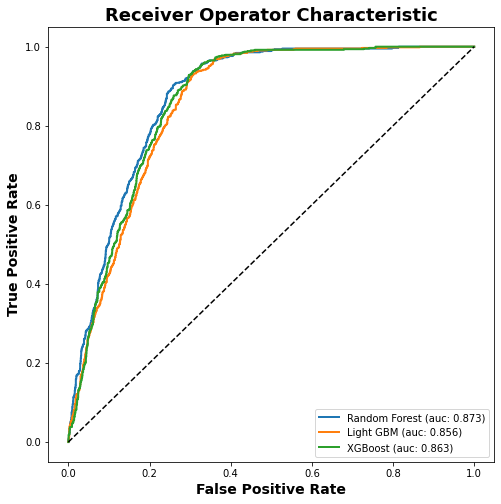

In [108]:
# Plot the ROC curve using only the pyplot API
plt.figure(figsize=(8,8))
plt.plot(fpr_rf, tpr_rf, lw=2, label='Random Forest (auc: {:.03f})'.format(roc_auc_rf))
plt.plot(fpr_lgbm, tpr_lgbm, lw=2, label='Light GBM (auc: {:.03f})'.format(roc_auc_lgbm))
plt.plot(fpr_xgb, tpr_xgb, lw=2, label='XGBoost (auc: {:.03f})'.format(roc_auc_xgb))
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.legend(loc=4)

plt.title('Receiver Operator Characteristic', fontweight='bold', fontsize=18)
plt.xlabel('False Positive Rate', fontweight='bold', fontsize =14)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=14);

# plt.savefig('./article/roc.png', dpi=400, bbox_inches='tight')

The random forest model out performs the boosting models on this data set. This is consistent with what I've casually come to understand from practicing data scientists though various presentations, which is for smaller data sets random forest performs better than boosting models. 

## Model Analysis
Let's take a deeper look at the results of the random forest model by examining the results of the confusion matrix.

In [109]:
# Write a quick function to print confusion matrix nicely
def con_mat(model, X, y):
    y_preds = model.predict(X)
    TN = confusion_matrix(y, y_preds)[0][0] # True negatives
    FP = confusion_matrix(y, y_preds)[0][1] # True negatives
    FN = confusion_matrix(y, y_preds)[1][0] # True negatives
    TP = confusion_matrix(y, y_preds)[1][1] # True negatives
    print(f'model: {model.__getattribute__}\n')
    print('Results:')
    print(f'\t\t\tPredictions')
    print(f'\t\t\t0\t1\tTotal')
    print(f'Observations\t0\t{TN}\t{FP}\t{TN+FP}')
    print(f'\t\t1\t{FN}\t{TP}\t{FN+TP}')
    print(f'\t\tTotal\t{TN+FN}\t{FP+TP}\t{TN+TP+FN+FP}')

In [110]:
# Let's look at the confusion matrix for the random forest model
con_mat(rf_best_model, X_test, y_test)

model: <method-wrapper '__getattribute__' of RandomForestClassifier object at 0x7f833bcb4dd8>

Results:
			Predictions
			0	1	Total
Observations	0	1630	269	1899
		1	234	400	634
		Total	1864	669	2533


In order to evaluate how good the 80% accuracy of the random forest model is we need to create a baseline to which to compare it. Let's first calculate what the accuracy of the model would be if we simply predicted the mode in every case.

In [111]:
1899 / 2533

0.7497039084090011

So compared to the naive model producing an accuracy of 75%, the 80% accuracy of our random forest model seems meager. Yet a better baseline may be one that proportions the errors based on the observed values.

Let's recalculate the baseline accuracy with the following error counts (Menard 1995):

$$Errors = \sum_{i} \frac{f_{i}(N-f_{i})}{N}$$

$N$ = Total number of cases

$f_{i}$ = The number of cases in each category

This is equivalent to the following confusion matrix:

|  | 0 | 1 | Total |
| --- | --- | --- | --- |
| 0 | 1424 | 475 | 1899 |
| 1 | 475 | 159 | 634 |
| Total | 1899 | 634 | 2533 |

In [112]:
# Calculate the number of errors and the new baseline accuracy
errors = (1899*(2533-1899) + 634*(2533-634))/2533
accuracy = (2533-errors)/2533
print(errors)
print(accuracy)

950.6245558626135
0.6247040837494617


Comparing the random forest accuracy of 80% to this baseline accuracy of 62.4% the improvement seems notable but not great. That being said, we can still gain some insights into the ADU completion rates from examining the feature importances.

## Feature Importances

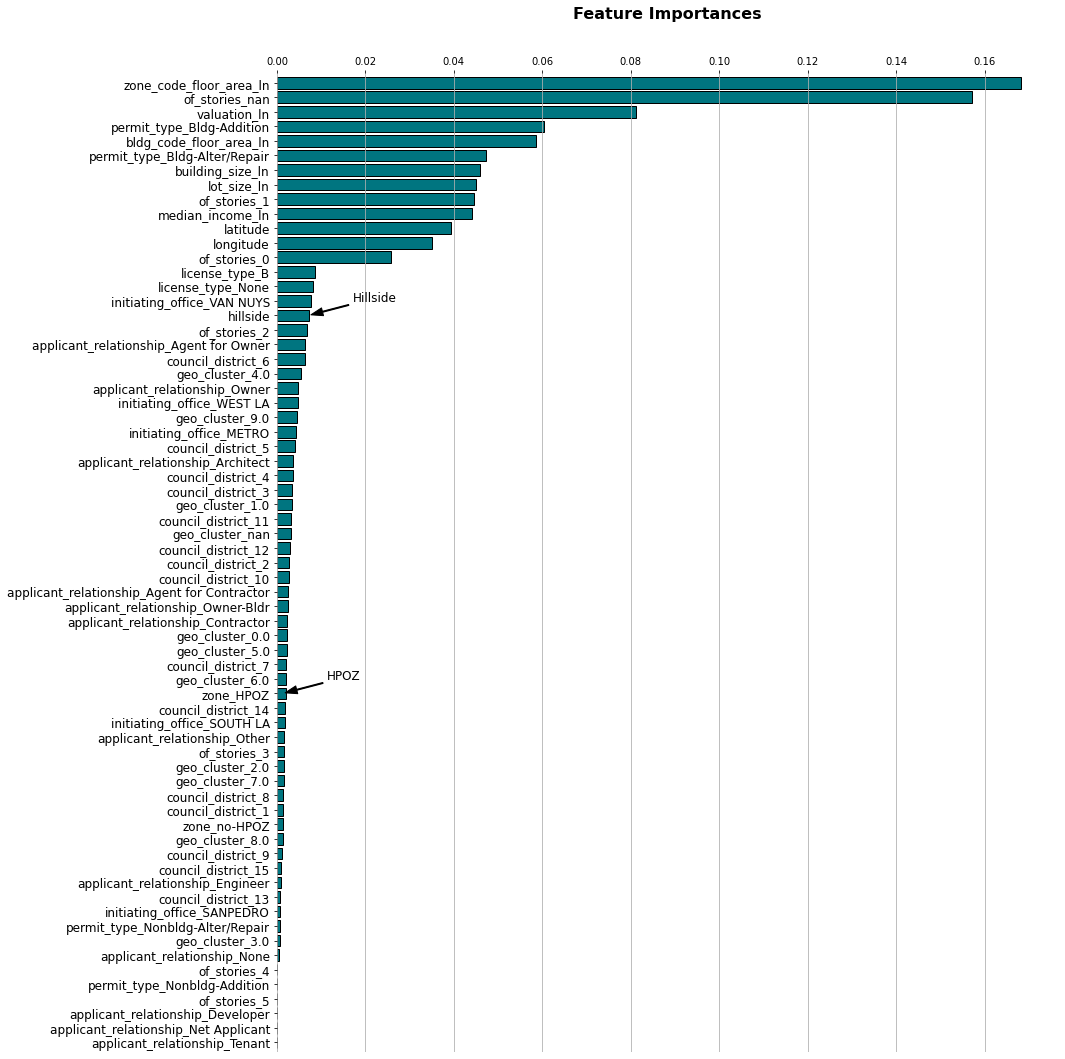

In [116]:
# Plot the feature importances sorted
features = X_train.columns
feature_importances = pd.Series(rf_best_model.feature_importances_)
feature_importances.index = features
feature_importances = feature_importances.sort_values(ascending=True)
feature_importances.plot(kind='barh', figsize=(14,18), color='#007580', width=0.8, edgecolor='black', 
                         fontsize=12)
plt.grid(axis='x')
plt.xlabel('')
plt.title('Feature Importances', fontsize=16, fontweight='bold', y=1.05)

ax = plt.gca()
ax.set_frame_on(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

hillside_index = feature_importances.index.get_loc('hillside')
hpoz_index = feature_importances.index.get_loc('zone_HPOZ')
                                                   
ax.annotate('Hillside', xy=(feature_importances['hillside'], hillside_index), 
            xytext=(feature_importances['hillside']+0.01, hillside_index+1), 
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8), fontsize=12)
ax.annotate('HPOZ', xy=(feature_importances['zone_no-HPOZ'], hpoz_index), 
            xytext=(feature_importances['zone_no-HPOZ']+0.01, hpoz_index+1), 
            arrowprops=dict(facecolor='black', shrink=.05, width=1, headwidth=8), fontsize=12);

# plt.savefig('./article/feats.png', dpi=400, bbox_inches='tight')

As a further check on feature importances, I'm going to write a loop in which I remove a feature one at a time and re-fit the model without re-tuning the hyperparameters in order to confirm the number of features that can be dropped from the model.

In [137]:
remove_lowest_n = list(np.arange(1,66,1))
scores = []

for n in remove_lowest_n:
    subset_features = pd.Series(rf_best_model.feature_importances_, index=features).sort_values()[n:].index
    score = cross_val_score(RandomForestClassifier(max_depth=10, min_samples_leaf=1), X_train[subset_features], y_train, 
                            cv=KFold(n_splits=3, shuffle=True), scoring='accuracy').mean()
    scores.append(score)
    print(f'Remove {n} features (keep {len(features)-n} features): score = {score:.03f}')

Remove 1 features (keep 66 features): score = 0.784
Remove 2 features (keep 65 features): score = 0.782
Remove 3 features (keep 64 features): score = 0.780
Remove 4 features (keep 63 features): score = 0.783
Remove 5 features (keep 62 features): score = 0.783
Remove 6 features (keep 61 features): score = 0.786
Remove 7 features (keep 60 features): score = 0.791
Remove 8 features (keep 59 features): score = 0.784
Remove 9 features (keep 58 features): score = 0.785
Remove 10 features (keep 57 features): score = 0.787
Remove 11 features (keep 56 features): score = 0.787
Remove 12 features (keep 55 features): score = 0.785
Remove 13 features (keep 54 features): score = 0.787
Remove 14 features (keep 53 features): score = 0.787
Remove 15 features (keep 52 features): score = 0.786
Remove 16 features (keep 51 features): score = 0.785
Remove 17 features (keep 50 features): score = 0.785
Remove 18 features (keep 49 features): score = 0.785
Remove 19 features (keep 48 features): score = 0.792
Re

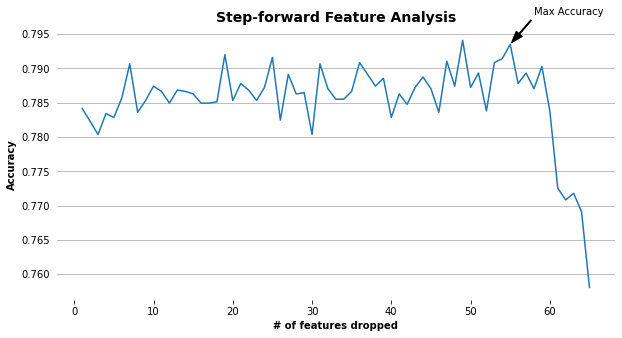

In [140]:
# Plot the results
plt.figure(figsize=(10,5))
plt.plot(remove_lowest_n, scores)
plt.title('Step-forward Feature Analysis', fontweight='bold', fontsize=14)
plt.xlabel('# of features dropped', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.grid(axis='y')

ax=plt.gca()
ax.set_frame_on(False)
ax.yaxis.set_ticks_position('none')
xmin, xmax = ax.get_xlim()
ax.add_artist(Line2D((xmin,xmax),(0,0), color='black', linewidth=2))

remove = 55
ax.annotate('Max Accuracy', xy=(remove, scores[remove-1]), xytext=(remove+3, scores[remove]+0.01), 
            arrowprops=dict(facecolor='black', shrink=.05, width=1, headwidth=8));

# plt.savefig('./article/step_forward.png', dpi=400, bbox_inches='tight')

The best model is keeping the top 12 features, and removing the bottom 55, thus retaining `zone_code_floor_area_ln`, `bldg_code_floor_area_ln`, `of_stories_ln`, `valuation_ln`, `permit_type`, `lot_size`, `latitude` and `longitude`. We would remove all of the geo_clusters, the hillside and HPOZ variables, `applicant_relationship`, council districts, initiating offices and `license_type`.

# The Takeways
The random forest model was the best performing model of the three tested, which demonstrates the utility of random forest for smaller data sets of less than, say, 10,000 records. While the predictive accuracy of the model still isn't great its not so bad that insights cannot be drawn from the results. 

Returning to the radio segment that started this project off, a historic preservation overlay zone didn't turn out to have a significant contribution to this model, but then it was only 4.1% of the data set. Hillsides at 21.8% would have had a greater chance at influencing the completion probability, but ultimately other variables were more powerful.

Those that rose to the top were mostly "magnitude" variables - floor sizes, lot sizes, valuations. This suggests that the bigger and more expensive the project, the more likely it will be completed within two years from the time the permit is issued. 

Furthermore, the two year time period of the analysis was quite long. A lot of changes can happen to a project within that time period, size and scope morph, items are added and deleted, all of which affects the probability of completion. 

Seeing the results of this model is causing me to form a new theory regarding the completion rates of ADU's once permitted. If the owner of the site gets as far as obtaining a permit to build, they are already committed to the project. Given sufficient resources the owner will probably overcome the project's challenges. Those challenges may more strongly influence the time to completion than the probability of completion. Thus, what might be a more insightful analysis would be a prediction of the time to completion. The next step would to build such a model.